# Integrantes

* Angelo Rossi - RM365902
* Carlos Eduardo Arlindo - RM365213
* Felipe Goiabeira - RM365753
* Guilherme Groff - RM365281
* Rafael Lua - RM366254

In [77]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action='ignore')

In [78]:
def print_feature_distribution(dataset, feature_name):
    histogram = px.histogram(dataset, x=feature_name, color="diagnostico", marginal="box")
    histogram.update_layout(bargap=0.2, bargroupgap=0.1, yaxis_title='Count',
                            title=f'Histograma de {feature_name} por diagnostico')
    histogram.show()

# Formato da base de dados

## Sobre

Todos os pacientes são mulheres com pelo menos 21 anos e de ascendência.

## 1. Análise exploratória dos dados (EDA):

Importar base de dados

In [42]:
!pip install -q kagglehub

import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("mathchi/diabetes-data-set")

print("Dataset downloaded to:", path)

csv_path = os.path.join(path, "diabetes.csv")

original_dataset = pd.read_csv(csv_path)

print("Formato:", original_dataset.shape)


Dataset downloaded to: /kaggle/input/diabetes-data-set
Formato: (768, 9)


Informações básicas sobre a base de dados

In [43]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Em análise inicial vemos que o dataset tem o formato de tabela com 768 registros com 9 colunas sendo que, nenhuma do tipo texto.

In [44]:
original_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**O dataset é composto pelas colunas:**
* Pregnancies: Número de vezes grávida
* Glucose: Concentração de glicose plasmática a 2 horas num teste de tolerância oral à glicose
* BloodPressure: Pressão arterial diastólica (mm Hg)
* SkinThickness: Espessura da prega cutânea do tríceps (mm)
* Insulin: Insulina sérica de 2 horas (mu U/ml)
* BMI: Índice de massa corporal (peso em kg/(altura em m)^2)
* diabétesPedigreeFunction: Função de pedigree do diabétes
* Age: Idade (anos)
* Outcome (variável target): Variável de classe (0 ou 1)


Teremos como variável "target" a coluna "Outcome".

In [45]:
original_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


Para fácilitar a leitura iremos modificar o nome das colunas.

Vamos traduzir os nomes

In [46]:
original_dataset.columns = [
    'gravidez',
    'glicose',
    'pressao_arterial',
    'espessura_pele',
    'insulina',
    'imc',
    'historico_familiar_diabetes',
    'idade',
    'diagnostico'
]

Dataset com as colunas renomeadas

In [47]:
original_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
gravidez,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glicose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
pressao_arterial,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
espessura_pele,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulina,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
imc,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
historico_familiar_diabetes,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
idade,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
diagnostico,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### 1.1 Verificando a existencia de valores nulos

In [48]:
original_dataset.isnull().sum()

,0
gravidez,0
glicose,0
pressao_arterial,0
espessura_pele,0
insulina,0
imc,0
historico_familiar_diabetes,0
idade,0
diagnostico,0


Aparentemente o dataset não tem nenhum valor nulo.

### 1.2 Distribuição dos Dados

#### 1.2.1 Distribuição da variável target (Diagnostico)

In [49]:
total = len(original_dataset)
diabetics = original_dataset[original_dataset['diagnostico'] == 1].diagnostico.count()
non_diabetics = original_dataset[original_dataset['diagnostico'] == 0].diagnostico.count()

print(f"Total de registros: {total}")
print(f"Diabeticos: {diabetics} - {100 * diabetics / total:.2f}% do total de registros")
print(f"Não Diabeticos: {non_diabetics} - {100 * non_diabetics / total:.2f}% do total de registros")

Total de registros: 768
Diabeticos: 268 - 34.90% do total de registros
Não Diabeticos: 500 - 65.10% do total de registros


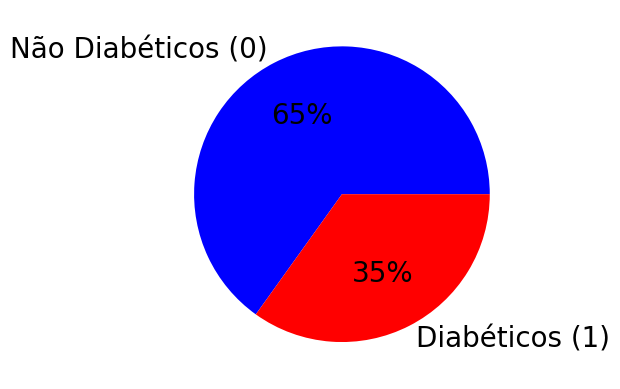

diagnostico                           0           1
gravidez                       3.298000    4.865672
glicose                      109.980000  141.257463
pressao_arterial              68.184000   70.824627
espessura_pele                19.664000   22.164179
insulina                      68.792000  100.335821
imc                           30.304200   35.142537
historico_familiar_diabetes    0.429734    0.550500
idade                         31.190000   37.067164


In [50]:
colors = ['blue', 'red']
labels = ['Não Diabéticos (0)', 'Diabéticos (1)']

plt.pie(original_dataset['diagnostico'].value_counts(), labels=labels, colors=colors, autopct='%1.0f%%',
        textprops={'fontsize': 20})
plt.show()
print(original_dataset.groupby("diagnostico").mean().T)

#### 1.2.1 Distribuição das features por target

##### 1.2.1.1 Feature Gravidez

In [51]:
print_feature_distribution(original_dataset, 'gravidez')

Histograma de diagnósticos de diabetes relacionado ao número de vezes que a paciente engravidou. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Observa-se que, até a 6ª gravidez, o número de mulheres saudáveis era maior que o número de mulheres diabéticas. A partir da 7ª, o número de mulheres diagnosticadas com diabetes se torná levemente maior (desconsiderando a 10ª gravidez, que apresenta um número similar). A partir da 13ª, todos os pacientes avaliados apresentaram diabetes.  


##### 1.2.1.2 Feature Glicose

In [52]:
print_feature_distribution(original_dataset, 'glicose')

Histograma de níveis de glicose relacionado ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Ao analisar o histograma, observa-se a presença de valores de Glicose zerados. Tais valores são considerados inválidos, visto que ilustram cenários impossíveis para pacientes considerados tanto diabéticos quanto saudáveis. Estes valores serão ajustados futuramente no código a partir da substituição dos dados pela mediana.

Levando em consideração as outras características do histograma, evidencia-se a presença de pacientes diabéticos apenas a partir da faixa 75-79. Ao que indica em uma análise inicial, o número de diagnosticados com a doença aumenta proporcionalmente ao valor da glicose do paciente, alcançando a maioria dos
indivíduos a partir de 155XXX. Com base em tal constatação, a glicose pode ter uma relação direta com o diagnóstico de diabetes.

##### 1.2.1.3 Feature Pressão Arterial

In [53]:
print_feature_distribution(original_dataset, 'pressao_arterial')

Histograma de pressão arterial relacionado ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Em uma primeira análise do histograma, observa-se a presença de valores zerados na pressão arterial. Tais informações são consideradas inválidas, visto que demonstram uma situação impossível aos pacientes, tanto diabéticos quanto saudáveis. Estes valores serão substituídos em análises futuras a partir da substituição dos dados pela mediana.

O gráfico demonstra que, apesar do número elevado de pressão arterial, o número de pacientes diabéticos é menor que a quantidade de saudáveis independente da pressão (desconsiderando algumas raras vezes nos intervalos entre 100-104mmHG e 110-114mmHG). Ao que indica, a pressão arterial não demonstra uma relação tão expressiva para o diagnóstico de diabetes.


##### 1.2.1.4 Feature Espessura da Pele

In [54]:
print_feature_distribution(original_dataset, 'espessura_pele')

Histograma de espessura da pele relacionada ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

De primeira vista, observa-se uma quantidade exorbitante de valores inválidos na espessura da pele. Devido a se demonstrarem zerados, ilustram um cenário impossível aos pacientes tanto saudáveis quanto diagnosticados com a doença, e por conta disso serão substituídos em análises futuras a partir de uma substituição dos dados pela mediana.
Em uma análise inicial, o histograma demonstra que o número dos diagnosticados com diabetes aumenta proporcionalmente à espessura da pele em relação aos pacientes saudáveis. Após a faixa de 45-49mm, chegam a superar o número de saudáveis, porém, não se mantém na mesma proporção. Isso pode indicar a não relação direta entre a espessura da pele e o diagnóstico de diabetes.


##### 1.2.1.5 Feature Insulina

In [55]:
print_feature_distribution(original_dataset, 'insulina')

Histograma de insulina relacionada ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Assim como na espessura de tela, observa-se uma grande quantidade de leituras zeradas consideradas impossíveis para o cenário. Tais valores serão ajustados no código para não interferir em futuras análises.

O histograma também demonstra um aumento na quantidade de usuários diagnosticados com diabétes entre as faixas 100 a 200mu U/ml. Tal constatação leva a indicar uma possivel relação entre o aumento de insulina e a presença diabétes, porém, devido ao alto número de valores invalidos, torna-se díficil estabelecer uma conexão concisa.  


##### 1.2.1.6 Feature IMC

In [56]:
print_feature_distribution(original_dataset, 'imc')

Histograma de IMC relacionado ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

Apesar do gráfico também demonstrar a presença de valores inválidos, acredita-se que não são em uma quantidade grande o suficiente para afetar a distribuição dos dados.

Em uma análise inicial do histograma, a maior proporção de diagnósticos positivos para diabetes atinge o ápice na faixa entre 31 e 32.9, mas logo em seguida começa a reduzir. Isso pode indicar a não relação direta entre o IMC e pacientes diabéticos, porém, o número de pacientes saudáveis é consideravelmente maior em IMCs mais baixos. Embora não relacionado diretamente, pacientes com IMC maiores demonstram mais chances de desenvolverem diabetes.


##### 1.2.1.7 Feature Idade

In [57]:
print_feature_distribution(original_dataset, 'idade')

Histograma de Idade relacionado ao diagnóstico de diabetes. Em vermelho os pacientes saudáveis, em azul aqueles diagnosticados com diabetes.

As leituras de idade não possuem valores inválidos.

Em uma análise inicial do gráfico, observa-se uma distribuição de pacientes diabéticos mais presente em idades avançadas, enquanto os saudáveis demonstram uma maior presença na juventude. A partir de tal constatação, é possível inferir a correlação entre idade e diabetes, sendo quanto mais velho, maior a chance de desenvolver a doença.


#### 1.2.2 Correlação entre Glicose e Insulina

Devido o comportamento similar entre as features de insulina e glicose no diagnostico de diabétes, vamos analisar como as duas se relacionam

In [58]:
scatter = px.scatter(original_dataset, x='insulina', y='glicose', color='glicose', trendline="ols")
scatter.update_layout(margin=dict(t=0, b=0, l=0, r=0), title='Distribuição de glicose por insulina')
scatter.show()

Embora se tenha a presença de valores inválidos para glicose e insulina, podemos notar que a linha de tendência mostra uma relação direta ente a leitura de insulina e a leitura de glicose, isso mostra que ambos tem relação de influência direta no diagnóstico de diabétes.

As features onde valor igual a zero e são invalidas:

* Glicose
* Pressão Arterial
* Espessura da Pele
* Insulina

As features de Insulina e Espessura da Pele tem a distribuição dos seus dados afetados pelo grande número de medições inválidas presente na pele, isso é perceptivel pelo limite inferior e o primeiro Quartil estarem igualados em zero.

Embora nas outras features os valores iguais a 0 são marcadas como outliers pelos gráficos de Caixa o cálculo da distribuição dos dados ainda podem ser afetados por eles.

Antes de verificarmos se tratar esses valores inválidos modificara a distribuição dos dados, devemos analisar a correlação atual entre as features e o diagnóstico de diabétes do paciente.

### 1.3 Correlação entre as features

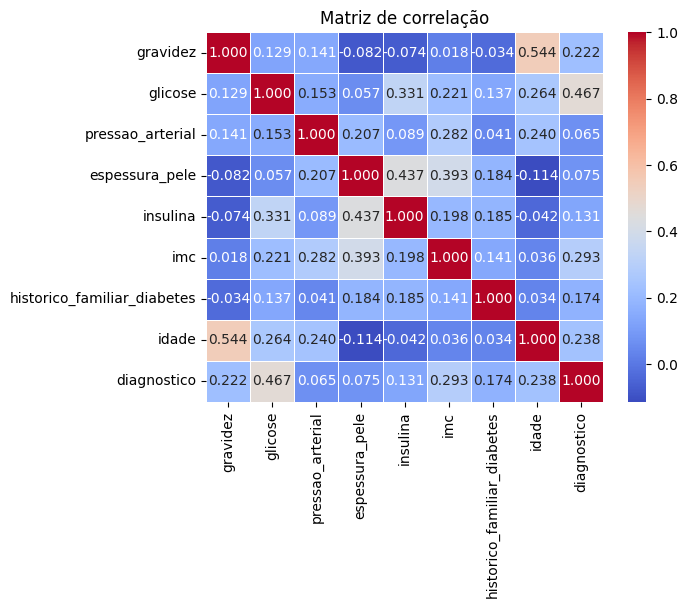

In [59]:
def print_features_correlation(dataset):
    dataset_correlation = dataset.corr()
    sns.heatmap(data=dataset_correlation, annot=True, linewidths=.5, fmt=".3f", cmap="coolwarm")
    plt.title("Matriz de correlação")
    plt.show()


print_features_correlation(original_dataset)

**Analise do gráfico de calor**

Uma tabela de correlação é uma forma bem útil de visualizar a relação entre variáveis quantitativas. Quanto mais próxima do zero, menor é a correlação entre as duas colunas analisadas. Ao se aproximar de 1 ou -1, a relação é considerada mais forte, tornando-se positiva ou negativa.

Se o valor estiver próximo a 1, a correlação é positiva: quanto maior for uma das variáveis, maior a tendência da outra também apresentar valores mais altos. Na imagem acima, tal comportamento é observado nas colunas de Age x Pregnancies (0.54) e Glicose x Outcome (0.47). Ou seja, numa análise inicial, quanto mais velhas as mulheres, maior a chance de terem engravidado durante a vida, e quanto maior o nível de glicose no sangue, maior a chance de terem sido diagnosticadas com diabétes.

Se o valor estiver próximo a -1, a correlação é negativa: quanto maior for uma das variáveis, maior a tendência da outra diminuir o seu valor. No entanto, na imagem acima não se demonstram exemplos que evidenciem esse comportamento, pois o valor mais próximo de -1 é observado entre as colunas Age x SkinThickness (-0.11), o que indica uma correlação muito fraca e provavelmente irrelevante.

Analisando o gráfico de calor, mesmo com valores inválidos em algumas features, é possível ver que:

* A principal feature é a **Glicose** com 0,467;
* Seguido pelo **IMC** (0,293) e a **idade** (0,238);
* As features com menor influência são: **pressão arterial** (0,065) e **espessura da pele** (0,075)

**Hipótese inicial**

As features **pressão arterial** e **espessura da pele** podem ter que ser removidas do conjunto de dados devido à baixa influência no diagnostic e o alto número de valores inválidos não impediu o diagnóstico do paciente.

### 1.4 Tratamento de valores inválidos

A presença de valores inválidos em algumas features foi tão grande que chegou a alterar a distribuição dos dados. Vamos remove-los para averiguar o impacto que eles tem sobre a relação de cada feature com o diagnóstico de diabétes.

In [60]:
total_features = len(original_dataset)

for feature in original_dataset.columns[:-1]:
    zero_count = original_dataset[original_dataset[feature] == 0][feature].count()
    percentage = 100 * zero_count / total_features
    print(f"{feature} com valor zero: {zero_count} ({percentage:.2f}% do total de registros)")

gravidez com valor zero: 111 (14.45% do total de registros)
glicose com valor zero: 5 (0.65% do total de registros)
pressao_arterial com valor zero: 35 (4.56% do total de registros)
espessura_pele com valor zero: 227 (29.56% do total de registros)
insulina com valor zero: 374 (48.70% do total de registros)
imc com valor zero: 11 (1.43% do total de registros)
historico_familiar_diabetes com valor zero: 0 (0.00% do total de registros)
idade com valor zero: 0 (0.00% do total de registros)


Para verificar a influência dos valores inválidos no diagnóstico de diabétes, foram utilizadas as estratégias:

* Substituir os valores inválidos pela mediana dos valores válidos de cada feature
* Substituir os valores inválidos pela mediana dos valores válidos de cada feature do diagnóstico correspondente

#### 1.4.1 Substituição dos valores inválidos pela mediana das features

In [61]:
dataset_without_invalid_values = original_dataset.copy()

for feature in dataset_without_invalid_values.columns[:-1]:
    no_zero_median = dataset_without_invalid_values[feature][dataset_without_invalid_values[feature] != 0].median()
    dataset_without_invalid_values[feature] = dataset_without_invalid_values[feature].replace(0, no_zero_median)

dataset_without_invalid_values.describe()

,gravidez,glicose,pressao_arterial,espessura_pele,insulina,imc,historico_familiar_diabetes,idade,diagnostico
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.423177,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,2.980481,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,4.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 1.4.2 Substituição dos valores inválidos pela mediana das feature estratificada por diagnóstico

In [62]:
dataset_median_per_outcome = original_dataset.copy()

for feature in dataset_median_per_outcome.columns[:-1]:
    for target_class in dataset_median_per_outcome['diagnostico'].unique():
        median = dataset_median_per_outcome[
            (dataset_median_per_outcome['diagnostico'] == target_class) & (dataset_median_per_outcome[feature] != 0)][
            feature].median()
        condition = (dataset_median_per_outcome['diagnostico'] == target_class) & (
                    dataset_median_per_outcome[feature] == 0)
        dataset_median_per_outcome.loc[condition, feature] = median

dataset_median_per_outcome.describe()

,gravidez,glicose,pressao_arterial,espessura_pele,insulina,imc,historico_familiar_diabetes,idade,diagnostico
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,4.377604,121.677083,72.389323,29.089844,141.753906,32.434635,0.471876,33.240885,0.348958
std,3.010736,30.464161,12.106039,8.890820,89.100847,6.880498,0.331329,11.760232,0.476951
min,1.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### 1.4.3 Comparação dos dados tratados

##### 1.4.3.1 Distribuição dos dados

###### 1.4.3.1.1 Feature Glicose

In [63]:
print('Dataset original')
print_feature_distribution(original_dataset, 'glicose')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'glicose')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'glicose')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


Com a remoção dos valores de glicose inválidos agora só se tem a presença de um outlier abaixo do limite mínimo dos pacientes sem diabétes. A distribuição dos dados exibido pelo diagrama de caixa se mantém similar ao do dataset com valores inválidos.

Substituir os dados inválidos usando a mediana da feature ou a mediana da feature por diagnóstico não apresentou uma diferença perceptivel na distribuição dos dados.

###### 1.4.3.1.2 Feature Pressão Arterial

In [64]:
print('Dataset original')
print_feature_distribution(original_dataset, 'pressao_arterial')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'pressao_arterial')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'pressao_arterial')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


Com a remoção dos valores de Pressão Arterial inválidos, podemos ver que a distribuição dos dados mostrou 3 outliers abaixo do limite mínimo nos pacientes não diabéticos. Os outliers acima do limite máximo de pacientes saudáveis se manteve.

Enquanto na distribuição de pacientes diabéticos, agora temos apenas duas ocorrências de outliers abaixo do límite mínimo e houve um aumento no número de outliers acima do limite máximo.

A diferença entre as abordagens de tratamento dos dados resultou na mudança na mediana na distribuição dos dados, os demais elementos continuaram iguais

###### 1.4.3.1.3 Feature Espessura da Pele

In [65]:
print('Dataset original')
print_feature_distribution(original_dataset, 'espessura_pele')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'espessura_pele')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'espessura_pele')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


A substituição dos valores inválidos pela mediana da feature resultou numa distribuição dos dados com a mesma mediana e tanto os pacientes com e sem diabétes tendo a mesma espessura de pele. No caso dos pacientes diabéticos no gráfico de caixa os paciêntes diabéticos tiveram o primeiro quartil sobreposto com a mediana dos dados.

Já na substituição dos valores inválidos pela mediana com base no tipo de diagnóstico resultou numa distribuição diferente, com a espessura da pele mediana dos diabéticos sendo maior do que a dos pacientes não diabéticos. Essa estratégia também apresentou um número maior de outliers acima e abaixo dos limites minimo e máximo da distribuição.

Isso indica que a espessura da pele poderia ser usada para o diagnóstico de diabétes

###### 1.4.3.1.3 Feature Insulina

In [66]:
print('Dataset original')
print_feature_distribution(original_dataset, 'insulina')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'insulina')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'insulina')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


O impacto dos valores inválidos na insulina também era bem grande, isso é perceptível pelos gráficos de caixa.

No conjunto de dados original a distribuição iniciava em zero, portanto não mostrava nenhum outlier abaixo do limite inferior em nenhum dos diagnósticos.

Em ambos os tratamentos aplicados para os valores inválidos podemos ver que existem diversos outliers acima e abaixo dos limites inferior e superior no conjunto de pacientes diabéticos.

_**Tem que analisar mais**_

###### 1.4.3.1.5 Feature IMC

In [67]:
print('Dataset original')
print_feature_distribution(original_dataset, 'imc')
print('Dataset com a mediana de cada feature')
print_feature_distribution(dataset_without_invalid_values, 'imc')
print('Dataset com a mediana de cada feature por diagnóstico')
print_feature_distribution(dataset_median_per_outcome, 'imc')

Dataset original


Dataset com a mediana de cada feature


Dataset com a mediana de cada feature por diagnóstico


No caso do IMC o uso da mediana da feature por diagnostico mostra que há um aumento no número de pacientes com diabétes se tiverem IMC alto

##### 1.4.3.2 Correlação entre as features

Dataset original


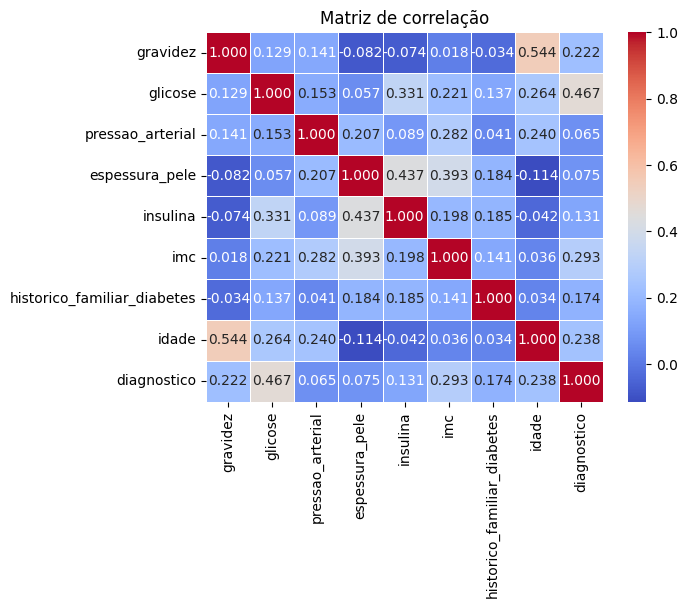

diagnostico                           0           1
gravidez                       3.298000    4.865672
glicose                      109.980000  141.257463
pressao_arterial              68.184000   70.824627
espessura_pele                19.664000   22.164179
insulina                      68.792000  100.335821
imc                           30.304200   35.142537
historico_familiar_diabetes    0.429734    0.550500
idade                         31.190000   37.067164
Dataset com a mediana de cada feature


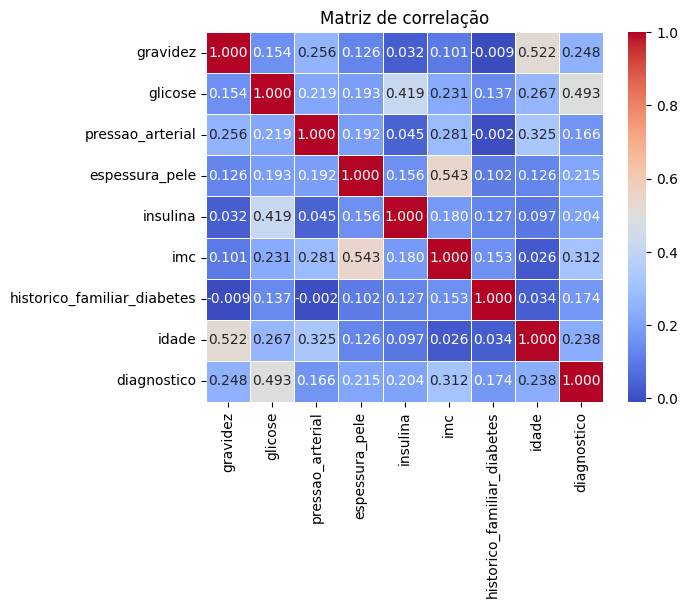

diagnostico                           0           1
gravidez                       3.882000    5.432836
glicose                      110.682000  142.130597
pressao_arterial              70.920000   75.123134
espessura_pele                27.726000   31.686567
insulina                     127.792000  164.701493
imc                           30.885600   35.383582
historico_familiar_diabetes    0.429734    0.550500
idade                         31.190000   37.067164
Dataset com a mediana de cada feature estratificado diagnóstico


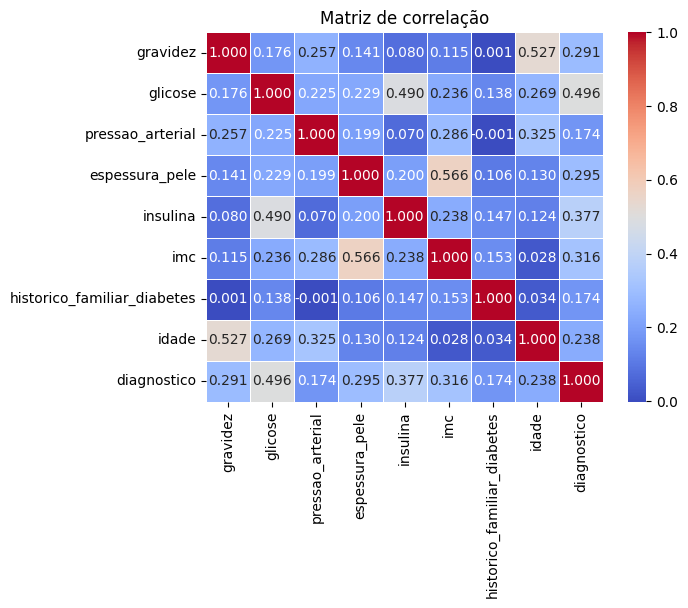

diagnostico                           0           1
gravidez                       3.736000    5.574627
glicose                      110.622000  142.302239
pressao_arterial              70.844000   75.272388
espessura_pele                27.170000   32.671642
insulina                     117.172000  187.615672
imc                           30.846000   35.398507
historico_familiar_diabetes    0.429734    0.550500
idade                         31.190000   37.067164


In [68]:
print('Dataset original')
print_features_correlation(original_dataset)
print(original_dataset.groupby("diagnostico").mean().T)
print('Dataset com a mediana de cada feature')
print_features_correlation(dataset_without_invalid_values)
print(dataset_without_invalid_values.groupby("diagnostico").mean().T)
print('Dataset com a mediana de cada feature estratificado diagnóstico')
print_features_correlation(dataset_median_per_outcome)
print(dataset_median_per_outcome.groupby("diagnostico").mean().T)

**Alterar o texto para usar a palavra estratificar. P.S. Não deixar esse comentario**

A remoção dos valores inválidos resultou no aumento da correlação das features com o diagnóstico

O dataset onde os dados inválidos foram substituidos pela mediana dos valores com base no diagnóstico apresentaram um valor de correlação maior com a váriavel target.

Mudanças: -- Precisa corrigir os valores
* A relação da Glicose aumentou de 0,47 para 0,49.
* A relação da Pressão Arterial foi de 0,065 para 0,166
* A relação da Espessura da Pele foi de 0,075 para 0,215
* A relação da Insulina foi de 0,13 para 0,214
* A ralação do IMC foi de 0,29 para 0,312

**Hipótese**

As features **pressão arterial** e **espessura da pele** podem ter que ser removidas do conjunto de dados. Ambas tiveram um ganho de relevancia muito grande após a remoção dos valores inválidos. A feature de **pressão arterial** e **espessura da pele** tiveram um incrível ganho de 146% e 140% respectivamente na sua correlação com a feature diagnostico, enquanto a feature **glicose** teve um ganho de apenas 4,25%. Mesmo assim a feature glicose é a que apresenta a maior correlação com o diagnóstico.

### 1.5 Análise multivariada

Vamos analisar o impacto das features na variância do modelo.

Como o dataset onde os dados inválidos substituidos foi o que apresentou maior correlação entre as features preditórias e a variável target, vamos usá-lo para as próximas análises.

In [69]:
X = dataset_median_per_outcome.drop('diagnostico', axis=1)
y = dataset_median_per_outcome['diagnostico']

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

pca_dataset = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
pca_dataset['diagnostico'] = y.values

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index=X.columns)

print('Variancia de cada componente:', pca.explained_variance_ratio_)
print('Variancia total explicada', round(sum(list(pca.explained_variance_ratio_)) * 100, 2))
print('------------------------------------------------------------------------------------')
print('Influencia de cada features no PCA')
print(loadings)

Variancia de cada componente: [0.30590285 0.17838581 0.14056561 0.11412937 0.09311291 0.06380336
 0.05749359]
Variancia total explicada 95.34
------------------------------------------------------------------------------------
Influencia de cada features no PCA
                                  PC1       PC2       PC3       PC4       PC5  \
gravidez                     0.333166  0.513609 -0.028960  0.170249 -0.406420   
glicose                      0.421319 -0.094611  0.445686 -0.260741  0.147658   
pressao_arterial             0.354715  0.233975 -0.300800 -0.069951  0.792986   
espessura_pele               0.395442 -0.300823 -0.418533 -0.007355 -0.362451   
insulina                     0.344886 -0.267255  0.520946 -0.305938 -0.084618   
imc                          0.400113 -0.373141 -0.420758 -0.001323 -0.049474   
historico_familiar_diabetes  0.154636 -0.288511  0.270552  0.885870  0.170686   
idade                        0.355451  0.536766  0.115129  0.140415 -0.118658   

        

**Analisar o que é o PCA**

Podemos reduzir a dimensionalidade de 8 features para 7 e representar 95,31% da variancia do dataset.

## 2. Pré Processamento de Dados

##### 2.3.1.3 SMOTE

In [70]:
from imblearn.over_sampling import SMOTE

X = pca_dataset.drop('diagnostico', axis=1)
y = pca_dataset['diagnostico']

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## 3. Treino do Modelo

Vamos separar X e Y do dataset gerado pelo PCA, pois tem uma dimensionalidade menor.

### 3.1 Escolha do melhor modelo através da validação cruzada

                 Model                                        Best Params  \
4     SVM (RBF Kernel)              {'clf__C': 10, 'clf__gamma': 'scale'}   
3        Random Forest  {'clf__max_depth': 10, 'clf__min_samples_split...   
0                  KNN  {'clf__metric': 'minkowski', 'clf__n_neighbors...   
2        Decision Tree  {'clf__max_depth': 5, 'clf__min_samples_split'...   
1  Logistic Regression  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol...   
5          Naive Bayes                                                 {}   

   Accuracy (median)  F1 (median)  Recall (median)  ROC AUC (median)  
4            0.87500     0.880952           0.9125          0.927812  
3            0.86250     0.867470           0.9000          0.938672  
0            0.82500     0.835294           0.8875          0.910000  
2            0.81250     0.825581           0.8375          0.812500  
1            0.79375     0.789809           0.7750          0.885625  
5            0.76250     0.746835 

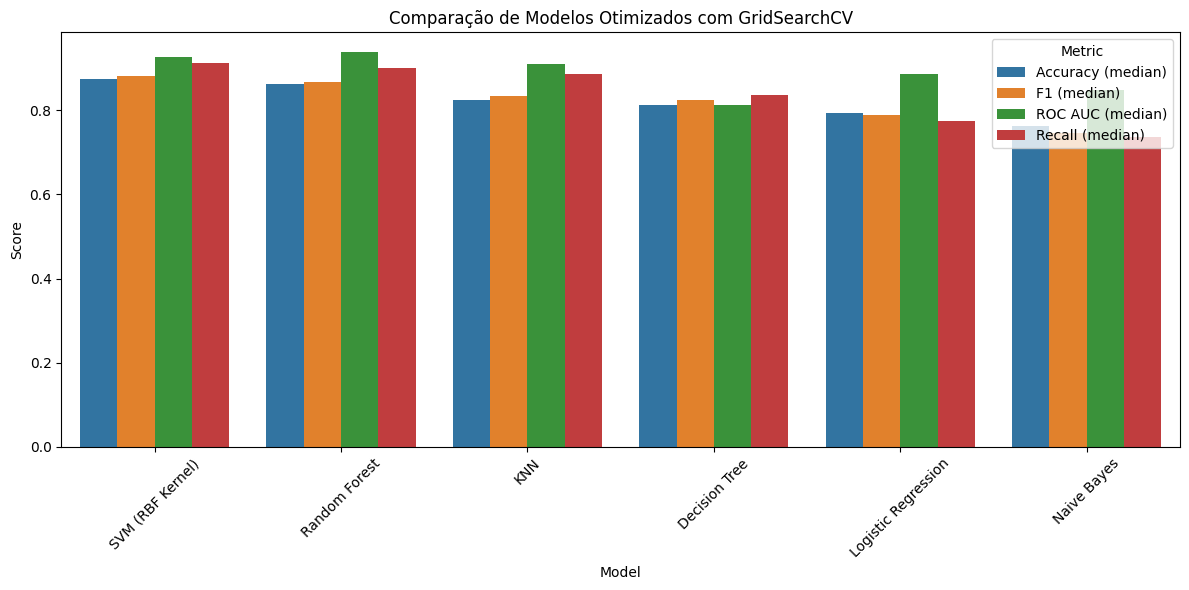

In [71]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM (RBF Kernel)': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

param_grids = {
    'KNN': {
        'clf__n_neighbors': [3, 5, 7, 9, 11],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['minkowski'],
        'clf__p': [1, 2]
    },
    'Logistic Regression': {
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    },
    'Decision Tree': {
        'clf__max_depth': [3, 5, 10, None],
        'clf__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 10, None],
        'clf__min_samples_split': [2, 5]
    },
    'SVM (RBF Kernel)': {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 'auto']
    },
    'Naive Bayes': {}
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'recall': 'recall'
}

results = []

best_overall_model = None
best_overall_score = -np.inf
best_overall_name = None

for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    param_grid = param_grids.get(name, {})

    grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='f1', n_jobs=-1)
    grid.fit(X_resampled, y_resampled)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = grid.best_score_

    if best_score > best_overall_score:
        best_overall_score = best_score
        best_overall_model = best_model
        best_overall_name = name

    scores = cross_validate(pipe, X_resampled, y_resampled, cv=cv, scoring=scoring)

    results.append({
        'Model': name,
        'Best Params': best_params,
        'Accuracy (median)': np.median(scores['test_accuracy']),
        'F1 (median)': np.median(scores['test_f1']),
        'Recall (median)': np.median(scores['test_recall']),
        'ROC AUC (median)': np.median(scores['test_roc_auc'])
    })

results_df = pd.DataFrame(results).sort_values(by='F1 (median)', ascending=False)
print(results_df)

results_melted = results_df.melt(id_vars=['Model'], value_vars=['Accuracy (median)', 'F1 (median)', 'ROC AUC (median)', 'Recall (median)'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Comparação de Modelos Otimizados com GridSearchCV')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Justificar a escolha das métricas. Indicar o significado de cada uma.

### 2.2 Divisão da base de dados em treino e teste

Dividimos o dataset obtido com o PCA em 20% para teste e 80% para treino, embaralhamos e balanceamos os dados antes de dividi-los.

In [72]:
print("Dados de Treino:")
print(y_train.value_counts(normalize=True))

print("Dados de Teste:")
print(y_test.value_counts(normalize=True))

Dados de Treino:
diagnostico
0    0.651466
1    0.348534
Name: proportion, dtype: float64
Dados de Teste:
diagnostico
0    0.649351
1    0.350649
Name: proportion, dtype: float64


### 2.3 Ajuste fino do modelo

In [73]:
def evaluate_model(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred) * 100,
        'Precision': precision_score(y_true, y_pred) * 100,
        'Recall': recall_score(y_true, y_pred) * 100,
        'F1 Score': f1_score(y_true, y_pred) * 100,
    }

previsions = {}
resultados = {}

#### 2.3.1 Estratégias

##### 2.3.1.1 Modelo base

In [74]:
#best_overall_model.fit(X_resampled, y_resampled)
best_overall_model.fit(X_train, y_train)
y_pred_base = best_overall_model.predict(X_test)

previsions['Base'] = y_pred_base
resultados['Base'] = evaluate_model(y_test, y_pred_base)

**Pesquisar melhor sobre o threshold**

Pesquisar o que são os valores passados para o threshold

In [75]:
y_proba = best_overall_model.predict_proba(X_test)[:, 1]
thresholds = [0.5, 0.45, 0.4, 0.35]

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    previsions[f'Threshold {t}'] = y_pred_thresh
    resultados[f'Threshold {t}'] = evaluate_model(y_test, y_pred_thresh)

**Pesquisar melhor sobre o threshold**

Pesquisar o que são os valores passados para o threshold

#### 2.3.2 Comparação dos Resultados

Previsões em valores absolutos


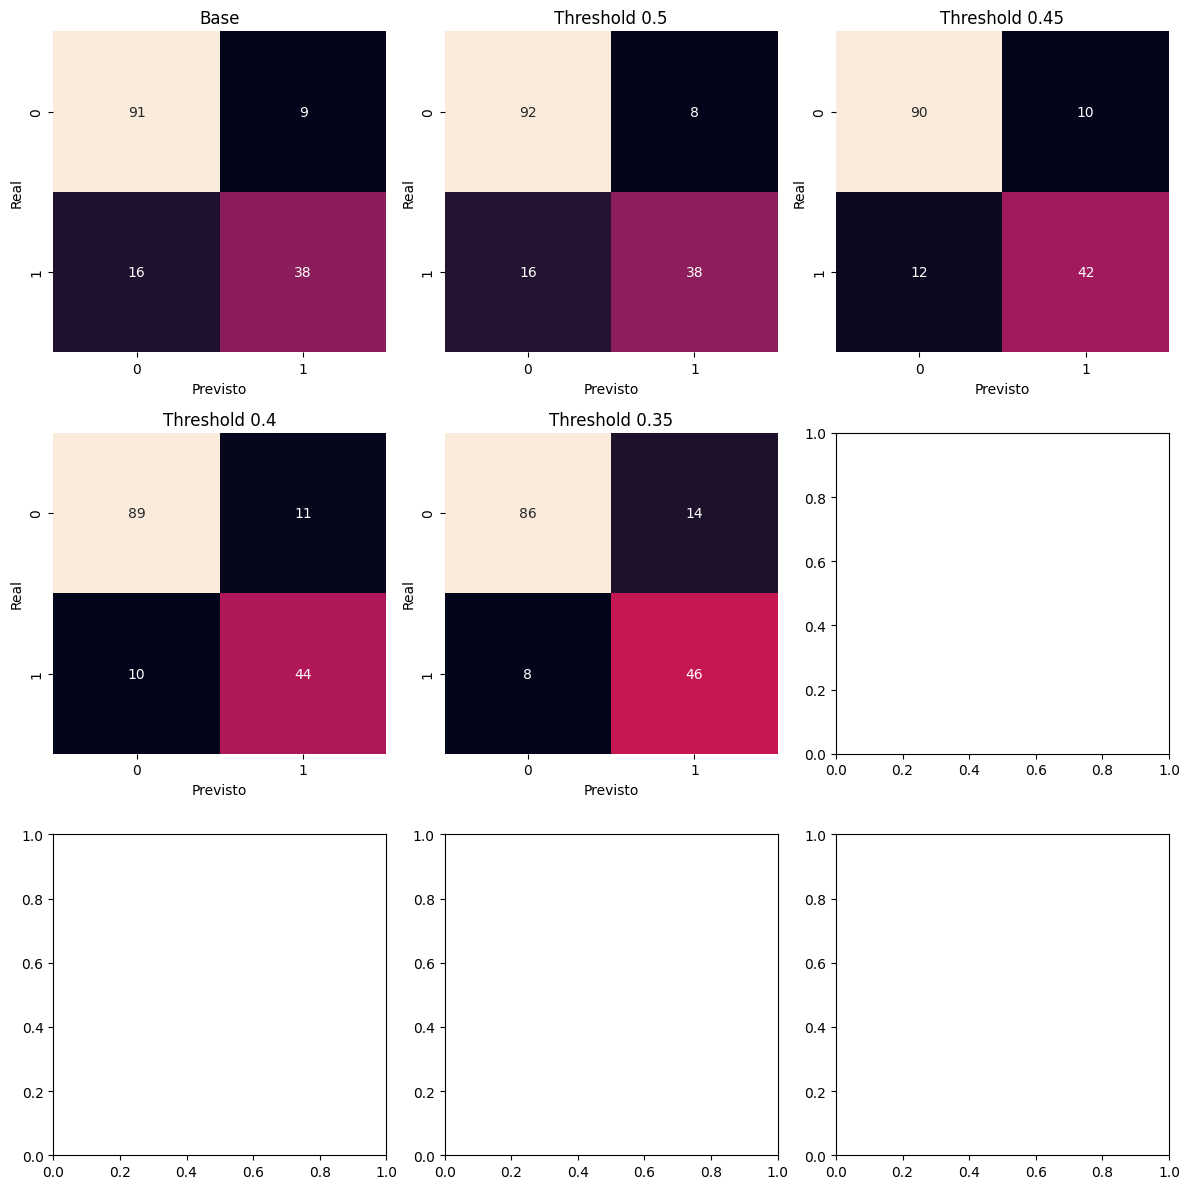

Previsões em porcentagem


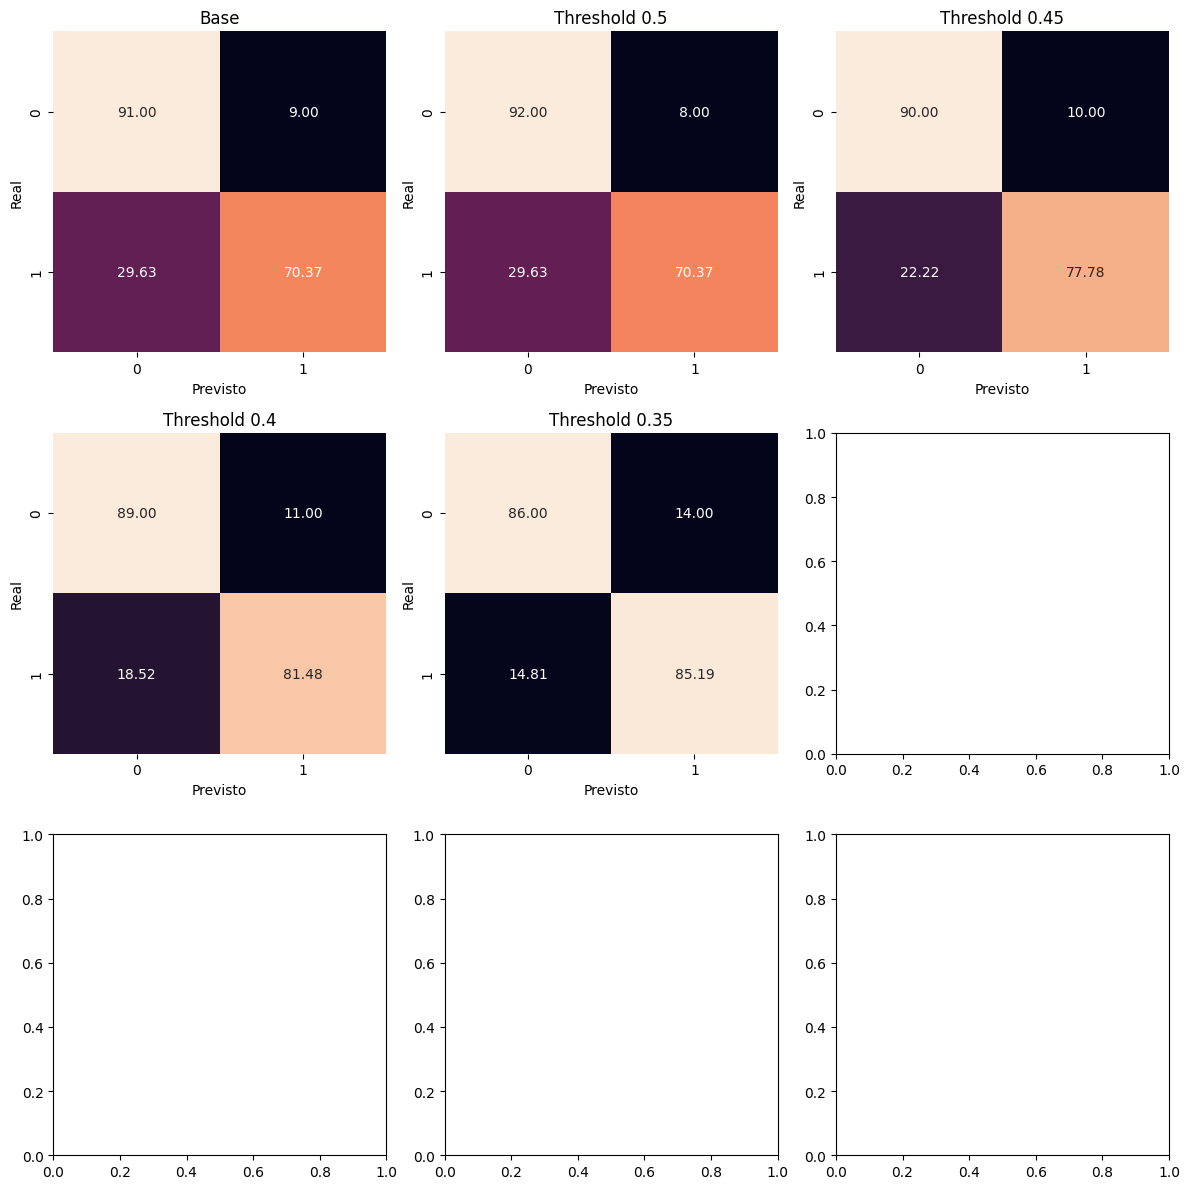

In [76]:
df_resultados = pd.DataFrame(resultados).T.reset_index().rename(columns={'index': 'Abordagem'})
df_resultados = df_resultados.melt(id_vars='Abordagem', var_name='Métrica', value_name='Valor')

fig = px.bar(df_resultados, x='Abordagem', y='Valor', text='Valor', title='Comparação de técnicas de pré processamento de dados',
                 labels={'Valor (%)': 'Valor (%)', 'Métrica': 'Métrica'}, color='Métrica')
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.show()

print('Previsões em valores absolutos')
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, (name, preds) in zip(axes.flatten(), previsions.items()):
    cm = confusion_matrix(y_true=y_test, y_pred=preds)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()

print('Previsões em porcentagem')
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, (name, preds) in zip(axes.flatten(), previsions.items()):
    cm = confusion_matrix(y_true=y_test, y_pred=preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt='.2f', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')
plt.tight_layout()
plt.show()


### Escrever conclusão da análise aqui
\



In [81]:
### parte 1 - Dataset (Angelo)

### parte 2 - Pré-processamento de dados (Goiabeira)

### Parte 3 - Modelagem e treinamento (Angelo e Goiabeira)